# Initialization

In [1]:
%matplotlib inline

In [2]:
import os

import numpy as np
import glob
import warnings
warnings.filterwarnings('ignore', message='No contour levels were found')
warnings.filterwarnings('ignore', message='Passing method to Float64Index.get_loc')
warnings.filterwarnings('ignore', message='All-NaN slice encountered')

import tempfile
import shutil

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath

mpl.rcParams['font.size'] = 10
mpl.rcParams['figure.dpi'] = 150
# # mpl.rcParams['pdf.use14corefonts'] = True
# # mpl.rcParams['pdf.fonttype'] = 42
# # mpl.rcParams['font.sans-serif'] = 'DejaVu Sans'
mpl.rcParams['hatch.linewidth'] = 0.5
mpl.rcParams['hatch.color'] = '0.25'

colors = ['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

import cmocean

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import xarray as xr
import xgcm

from numpy import pi as π

import sys

import pittwolfe as pw

In [3]:
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()

client = Client(cluster)
client

/Users/cwolfe/mambaforge/envs/py310/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60745 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:60745/status,
Dashboard: http://127.0.0.1:60745/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60746,Workers: 4
Dashboard: http://127.0.0.1:60745/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:60767,Total threads: 4
Dashboard: http://127.0.0.1:60768/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:60751,


# Specify the experiment

In [5]:
# expdir = '../2layer/flat/25km_newsponge'
# expdir = '../2layer/flat/25km'
# expdir = '../2layer/flat/25km_faster_sponge'
expdir = '../2layer/flat/25km_dt3600_uv_sponge'

# expdir = '../2layer/flat/5km_dt0600'
# expdir = '../2layer/flat/5km_test'
# expdir = '../2layer/flat/5km_dt0540'

# Load data

In [6]:
coord_map_h = {'lath': 'yh', 'latq': 'yq', 'lonh': 'xh', 'lonq': 'xq'}
coord_map_v = {'Interface': 'zi', 'Layer': 'zl'}

In [10]:
g = 9.8

try:
    grid.close()
except:
    pass

grid = xr.open_dataset(os.path.join(expdir, 'static.nc')).squeeze().drop('time')
grid.close()

ic = xr.open_dataset(os.path.join(expdir, 'OUTPUT/MOM_IC.nc')).squeeze().rename({**coord_map_h, **coord_map_v}).drop('Time')
ic.close()
grid['zi'] = ic.zi
grid['zl'] = ic.zl

Nx = len(grid.xh)
Ny = len(grid.yh)
Nl = len(grid.zl)

ρ0 = float(grid.zl.isel(zl=0))
grid['gprime'] = (('zl',), g*np.hstack(([1], (grid.zl.diff(dim='zl')/ρ0).values)))

Lx = float(grid.dxT.isel(yh=0).sum('xh'))/1e3
Ly = float(grid.dyT.isel(xh=0).sum('yh'))/1e3

grid

<xarray.Dataset>
Dimensions:      (xh: 320, yh: 120, xq: 321, yq: 121, zi: 3, zl: 2)
Coordinates:
  * xh           (xh) float64 12.5 37.5 62.5 ... 7.938e+03 7.962e+03 7.988e+03
  * yh           (yh) float64 -1.488e+03 -1.462e+03 ... 1.462e+03 1.488e+03
  * xq           (xq) float64 0.0 25.0 50.0 75.0 ... 7.95e+03 7.975e+03 8e+03
  * yq           (yq) float64 -1.5e+03 -1.475e+03 ... 1.475e+03 1.5e+03
  * zi           (zi) float64 1.034e+03 1.036e+03 1.038e+03
  * zl           (zl) float64 1.035e+03 1.037e+03
Data variables: (12/19)
    area_t       (yh, xh) float32 ...
    area_u       (yh, xq) float32 ...
    area_v       (yq, xh) float32 ...
    area_q       (yq, xq) float32 ...
    depth_ocean  (yh, xh) float32 ...
    wet          (yh, xh) float32 ...
    ...           ...
    dyCu         (yh, xq) float32 ...
    dxCv         (yq, xh) float32 ...
    dyCv         (yq, xh) float32 ...
    Idamp_u      (yh, xq) float32 ...
    Idamp_v      (yq, xh) float32 ...
    gprime       (zl) float64 9.8 0.01855
Attributes:
    NumFilesInSet:  1
    title:          MOM Experiment
    grid_type:      regular
    grid_tile:      N/A

In [11]:
grid_op = xgcm.Grid(grid, periodic=['X'], boundary='fill', fill_value=0, coords={
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': 'zl', 'outer': 'zi'},

})
grid_op

<xgcm.Grid>
X Axis (periodic, boundary='fill'):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary='fill'):
  * center   yh --> outer
  * outer    yq --> center
Z Axis (not periodic, boundary='fill'):
  * center   zl --> outer
  * outer    zi --> center

In [12]:
try:
    snapshot.close()
except:
    pass
snapshots = glob.glob(os.path.join(expdir, 'snapshot__????.nc'))
snapshots.sort()

# snapshot = xr.open_mfdataset(snapshots[-1], decode_times=False, chunks={'time': 1})
snapshot = xr.open_dataset(os.path.join(expdir, 'snapshot__0001.nc'), decode_times=False)
snapshot

<xarray.Dataset>
Dimensions:  (xq: 321, yh: 120, zl: 2, time: 720, xh: 320, yq: 121, zi: 3)
Coordinates:
  * xq       (xq) float64 0.0 25.0 50.0 75.0 ... 7.95e+03 7.975e+03 8e+03
  * yh       (yh) float64 -1.488e+03 -1.462e+03 ... 1.462e+03 1.488e+03
  * zl       (zl) float64 1.035e+03 1.037e+03
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 ... 717.0 718.0 719.0 720.0
  * xh       (xh) float64 12.5 37.5 62.5 87.5 ... 7.938e+03 7.962e+03 7.988e+03
  * yq       (yq) float64 -1.5e+03 -1.475e+03 -1.45e+03 ... 1.475e+03 1.5e+03
  * zi       (zi) float64 1.034e+03 1.036e+03 1.038e+03
Data variables:
    u        (time, zl, yh, xq) float32 ...
    v        (time, zl, yq, xh) float32 ...
    h        (time, zl, yh, xh) float32 ...
    e        (time, zi, yh, xh) float32 ...
Attributes:
    NumFilesInSet:     1
    title:             MOM Experiment
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A

## Animation of voriticty

In [13]:
def plot_frame(zeta, h, time, vms, ves, cmap, Lx, Ly):
    fig, ax = plt.subplots(figsize=(9, 3))
    fig.set_facecolor('w')

    xlim = (0, Lx)
    ylim = (-Ly/2, Ly/2)
    vmin = -vms/2
    vmax =  vms/2
    norm = mpl.colors.Normalize(vmin, vmax)

    pc = ax.pcolormesh(zeta.xh, zeta.yh, zeta, vmin=vmin, vmax=vmax, cmap=cmap)
        # ax.set_title('$\eta_' + str(n) + '$')
    ax.set_aspect(1)

    intensity = pw.plt.hillshade(35, 50, h, vertical_exageration=ves)
    rgb = pw.plt.blend_shade(cmap(norm(zeta)), intensity, mid_intensity=.75, min_brightness=.3, max_brightness=.9)
    im = ax.imshow(np.nan_to_num(rgb, nan=.7), origin='lower', extent=xlim + ylim, zorder=3)
    cbar = fig.colorbar(pc, ax=ax, extend='both', label='$10^{-5}$ s$^{-1}$', pad=0.025)

    ax.set_title('$t = {:3.0f}$ days'.format(float(time)))
    fig.tight_layout()

    return fig

### If using load_dataset

In [14]:
zeta = grid_op.interp(
    grid_op.interp(
        ((grid_op.diff(snapshot.v.fillna(0)*grid.dyCv, 'X') 
          - grid_op.diff(snapshot.u.fillna(0)*grid.dxCu, 'Y'))/grid.area_q), 
        'X'),
    'Y')
zeta.coords['time'] = zeta.time

In [15]:
vms = 1e5*np.abs(zeta).isel(zl=0).max(dim=('yh', 'xh','time')).values
vms

5.74125224375166

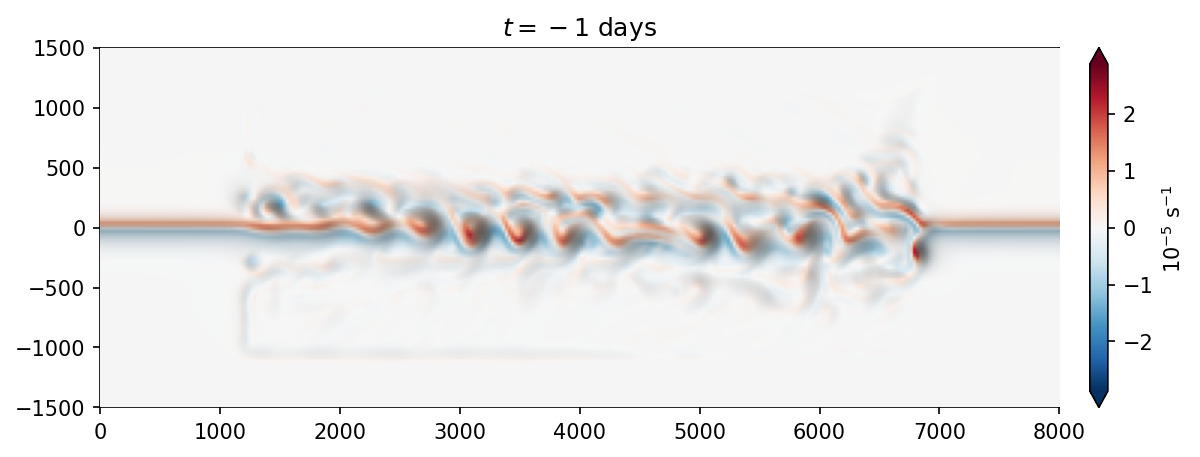

In [17]:
time = -1
ves = 2e-2
cmap = mpl.cm.RdBu_r
h = snapshot.h.isel(zl=0, time=time)
plot_frame(1e5*zeta.isel(zl=0,time=time), h, time, vms, ves, cmap, Lx, Ly);

In [18]:
framedir = tempfile.mkdtemp()
print(framedir)

/var/folders/mw/nq2xq7qd08s09mh886d_91rh0000gn/T/tmpwfij3aug


In [19]:
ves = 2e-2
cmap = mpl.cm.RdBu_r

for time in range(len(snapshot.time)):
    h = snapshot.h.isel(zl=0, time=time)
    with mpl.style.context({'font.size': 14}):
        fig = plot_frame(1e5*zeta.isel(zl=0,time=time), h, time, vms, ves, cmap, Lx, Ly)
        fig.savefig(os.path.join(framedir, 'frame_{:04d}.png'.format(time)), bbox_inches='tight', dpi=200)

        plt.close()

In [21]:
ffmpeg = 'ffmpeg'
name = os.path.join(expdir, 'zeta_h_spinup')
# name = os.path.join(expdir, 'zeta_h_equilibrium')
cmd = '{:s} -framerate 30 -y -pattern_type glob -i "{:s}/*.png" -codec:v libx264  -pix_fmt yuv420p -profile:v high -preset slow -vf scale="trunc(oh*a/2)*2:960, setpts=1.0*PTS" -threads 0 -vb 20M {:s}.mp4'.format(
    ffmpeg, framedir, name);
print(cmd)
os.system(cmd)

ffmpeg -framerate 30 -y -pattern_type glob -i "/var/folders/mw/nq2xq7qd08s09mh886d_91rh0000gn/T/tmpwfij3aug/*.png" -codec:v libx264  -pix_fmt yuv420p -profile:v high -preset slow -vf scale="trunc(oh*a/2)*2:960, setpts=1.0*PTS" -threads 0 -vb 20M ../2layer/flat/25km_dt3600_uv_sponge/zeta_h_spinup.mp4


ffmpeg version 4.4.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 13.1.6 (clang-1316.0.21.2.5)
  configuration: --prefix=/opt/local --enable-swscale --enable-avfilter --enable-avresample --enable-libmp3lame --enable-libvorbis --enable-libopus --enable-librsvg --enable-libtheora --enable-libopenjpeg --enable-libmodplug --enable-libvpx --enable-libsoxr --enable-libspeex --enable-libass --enable-libbluray --enable-libzimg --enable-libzvbi --enable-lzma --enable-gnutls --enable-fontconfig --enable-libfreetype --enable-libfribidi --enable-zlib --disable-libjack --disable-libopencore-amrnb --disable-libopencore-amrwb --disable-libxcb --disable-libxcb-shm --disable-libxcb-xfixes --disable-indev=jack --enable-opencl --disable-outdev=xv --enable-audiotoolbox --enable-videotoolbox --enable-sdl2 --disable-securetransport --mandir=/opt/local/share/man --enable-shared --enable-pthreads --cc=/usr/bin/clang --enable-libdav1d --enable-libaom --enable-librav1e --enable

0

In [22]:
shutil.rmtree(framedir)

### If using load_mfdataset

`xGCM` can't deal with MOM6's symmetric grid, so we have to fuck around a bit more. The main problem is we need the maximum value of the vorticity before we start. For small enough datasets we can just load up the whole thing.

In [9]:
# u = prog.u.isel(zl=0).fillna(0).load()
# v = prog.v.isel(zl=0).fillna(0).load()

zeta = 1e5*grid_op.interp(
    grid_op.interp(
        ((grid_op.diff(snapshot.v.isel(zl=0)*grid.dyCv, 'X') 
          - grid_op.diff(snapshot.u.isel(zl=0)*grid.dxCu, 'Y'))/grid.Aq), 
        'X'),
    'Y')

# del u, v

In [10]:
vms = float(np.abs(zeta).max(dim=('yh', 'xh','time')))
ves = 7e-2
cmap = mpl.cm.RdBu_r
vms

13.0614378170867

In [11]:
framedir = tempfile.mkdtemp()
print(framedir)

/var/folders/mw/nq2xq7qd08s09mh886d_91rh0000gn/T/tmph5pd0fkc


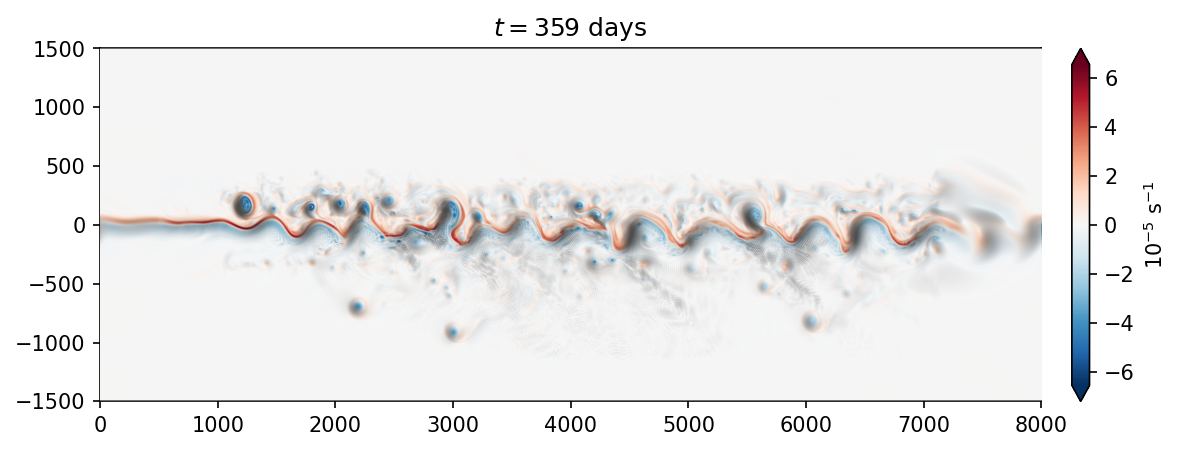

In [12]:
ves = 7e-2
cmap = mpl.cm.RdBu_r
time = -1

plot_frame(zeta.isel(time=time), snapshot.h.isel(zl=0, time=time), zeta.time.isel(time=time), vms, ves, cmap, Lx, Ly);

In [13]:
for time in range(0, len(snapshot.time)):
    with mpl.style.context({'font.size': 14}):
        fig = plot_frame(zeta.isel(time=time), snapshot.h.isel(zl=0, time=time), zeta.time.isel(time=time), vms, ves, cmap, Lx, Ly)
        fig.savefig(os.path.join(framedir, 'frame_{:04d}.png'.format(time)), bbox_inches='tight', dpi=200)

        plt.close()

In [14]:
ffmpeg = 'ffmpeg'
name = os.path.join(expdir, 'zeta_h_spinup')
cmd = '{:s} -framerate 15 -y -pattern_type glob -i "{:s}/*.png" -codec:v libx264  -pix_fmt yuv420p -profile:v high -preset slow -vf scale="trunc(oh*a/2)*2:960, setpts=1.0*PTS" -threads 0 -vb 20M {:s}.mp4'.format(
    ffmpeg, framedir, name);
print(cmd)
os.system(cmd)

ffmpeg -framerate 15 -y -pattern_type glob -i "/var/folders/mw/nq2xq7qd08s09mh886d_91rh0000gn/T/tmph5pd0fkc/*.png" -codec:v libx264  -pix_fmt yuv420p -profile:v high -preset slow -vf scale="trunc(oh*a/2)*2:960, setpts=1.0*PTS" -threads 0 -vb 20M ../2layer/flat/5km_dt0540/zeta_h_spinup.mp4


ffmpeg version 4.4.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 13.1.6 (clang-1316.0.21.2.5)
  configuration: --prefix=/opt/local --enable-swscale --enable-avfilter --enable-avresample --enable-libmp3lame --enable-libvorbis --enable-libopus --enable-librsvg --enable-libtheora --enable-libopenjpeg --enable-libmodplug --enable-libvpx --enable-libsoxr --enable-libspeex --enable-libass --enable-libbluray --enable-libzvbi --enable-lzma --enable-gnutls --enable-fontconfig --enable-libfreetype --enable-libfribidi --enable-zlib --disable-libjack --disable-libopencore-amrnb --disable-libopencore-amrwb --disable-libxcb --disable-libxcb-shm --disable-libxcb-xfixes --disable-indev=jack --enable-opencl --disable-outdev=xv --enable-audiotoolbox --enable-videotoolbox --enable-sdl2 --disable-securetransport --mandir=/opt/local/share/man --enable-shared --enable-pthreads --cc=/usr/bin/clang --enable-libzimg --enable-libdav1d --enable-libaom --enable-librav1e --enable

0

In [15]:
shutil.rmtree(framedir)

### If using load_mfdataset

`xGCM` can't deal with MOM6's symmetric grid, so we have to fuck around a bit more

In [18]:
framedir = tempfile.mkdtemp()
print(framedir)

/var/folders/mw/nq2xq7qd08s09mh886d_91rh0000gn/T/tmpaysc5l56


In [19]:
def load_and_plot_frame(prog, vms, ves, cmap, Lx, Ly):
    u = prog.u.isel(zl=0).fillna(0).load()
    v = prog.v.isel(zl=0).fillna(0).load()

    zeta = 1e5*grid_op.interp(
        grid_op.interp(
            ((grid_op.diff(v*grid.dyCv, 'X') - grid_op.diff(u*grid.dxCu, 'Y'))/grid.Aq), 
            'X'),
        'Y')
    
    h = prog.h.isel(zl=0)
    
    return plot_frame(zeta, h, prog.time, vms, ves, cmap, Lx, Ly)
    


In [20]:
vms = 4.5
ves = 2e-2
cmap = mpl.cm.RdBu_r

time = -1
load_and_plot_frame(prog.isel(time=time), vms, ves, cmap, Lx, Ly);

AttributeError: 'Dataset' object has no attribute 'h'

In [290]:
framedir = '/var/folders/mw/nq2xq7qd08s09mh886d_91rh0000gn/T/tmp2pscpjgz'

In [291]:
len(prog.time)

7200

In [292]:
vms = 4.5
ves = 2e-2
cmap = mpl.cm.RdBu_r

for time in range(3600, len(prog.time)):
    with mpl.style.context({'font.size': 14}):
        fig = load_and_plot_frame(prog.isel(time=time), vms, ves, cmap, Lx, Ly)
        fig.savefig(os.path.join(framedir, 'frame_{:04d}.png'.format(time)), bbox_inches='tight', dpi=150)

        plt.close()

In [296]:
ffmpeg = 'ffmpeg'
name = os.path.join(expdir, 'zeta_h_equilibrium')
cmd = '{:s} -y -pattern_type glob -i "{:s}/*.png" -codec:v libx264  -pix_fmt yuv420p -profile:v high -preset slow -vf scale="trunc(oh*a/2)*2:960, setpts=1.0*PTS" -threads 0 -framerate 10 -vb 20M {:s}.mp4'.format(
    ffmpeg, framedir, name);
print(cmd)
os.system(cmd)

ffmpeg -y -pattern_type glob -i "/var/folders/mw/nq2xq7qd08s09mh886d_91rh0000gn/T/tmp2pscpjgz/*.png" -codec:v libx264  -pix_fmt yuv420p -profile:v high -preset slow -vf scale="trunc(oh*a/2)*2:960, setpts=1.0*PTS" -threads 0 -framerate 10 -vb 20M ../2layer/flat/25km/zeta_h_equilibrium.mp4


ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 13.1.6 (clang-1316.0.21.2.5)
  configuration: --prefix=/opt/local --enable-swscale --enable-avfilter --enable-avresample --enable-libmp3lame --enable-libvorbis --enable-libopus --enable-librsvg --enable-libtheora --enable-libopenjpeg --enable-libmodplug --enable-libvpx --enable-libsoxr --enable-libspeex --enable-libass --enable-libbluray --enable-libzvbi --enable-lzma --enable-gnutls --enable-fontconfig --enable-libfreetype --enable-libfribidi --enable-zlib --disable-libjack --disable-libopencore-amrnb --disable-libopencore-amrwb --disable-libxcb --disable-libxcb-shm --disable-libxcb-xfixes --disable-indev=jack --enable-opencl --disable-outdev=xv --enable-audiotoolbox --enable-videotoolbox --enable-sdl2 --disable-securetransport --mandir=/opt/local/share/man --enable-shared --enable-pthreads --cc=/usr/bin/clang --enable-libzimg --enable-libdav1d --arch=x86_64 --enable-x86asm --enable-lib

0

In [17]:
shutil.rmtree(framedir)

# Close everything

In [23]:
snapshot.close()
grid.close()
ic.close()

client.close()
cluster.close()

In [4]:

client.close()
cluster.close()